In [1]:
import cv2
import json
import math
import os
import os.path
import re
import tempfile
import airsim
import numpy as np
from PIL import Image
from matplotlib import pyplot
import quickstart as util
import utils_KITTI as utilkitti

Using TensorFlow backend.
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/islab/.local/share/virtualenvs/depth_prediction-uX_uZt9E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) /

In [2]:
# 資料路徑
DATA_PATH = '/home/islab/Documents/drone/depth_prediction/data/random/data/2020-04-16-14-35/depth_planner/2020-04-16-14-37-04'
GREY_PIC_PATH = '/home/islab/Documents/drone/depth_prediction/result/vis_depth/2020-04-16-14-37-04/visualized_depth'
RESULT_PATH = '/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-04-16-14-37-04'

# Model Input 解析度設定
INPUT_HEIGHT = 320
INPUT_WIDTH = 384

#
ARROW_SIZE = 50

/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-04-16-14-37-04/3D_analysis_all/001.png
[2.99148909e+12 1.85306849e+12 1.35683274e+11 8.21689575e+10
 3.73787132e+05 2.02465710e+05 6.91294506e+06 1.19194200e+12]
[4.35018070e-01 2.95601923e-02 1.99055239e-05 2.27589822e-05
 2.23966402e-01 3.17777399e-01 9.86138469e-01 1.31474875e+00]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-04-16-14-37-04/3D_analysis_all/002.png
[3.35640874e+12 1.90108815e+12 3.28028591e+10 2.01252520e+09
 2.37309394e+04 2.83619793e+05 8.57639786e+06 1.48611924e+12]
[2.84583133e+00 8.10173898e-05 8.32239805e-04 8.23669519e-04
 3.39766602e-04 2.05438352e+00 1.50974384e+02 2.32760880e+02]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-04-16-14-37-04/3D_analysis_all/003.png
[3.59254393e+12 1.91812106e+12 6.66406672e+10 7.07960532e+04
 1.93529188e+04 1.96325404e+05 1.20518602e+07 1.74107534e+12]
[0.28273204 0.0022065  0.00541014 0.00574458 0.00286963 0.

/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-04-16-14-37-04/3D_analysis_all/037.png
[2.04698619e+12 2.63023178e+12 1.78984266e+12 2.82950084e+11
 1.56638545e+06 8.39716668e+05 1.68036628e+07 9.23664511e+11]
[4.62123748e-10 1.81511835e-03 8.76539886e-03 7.21814515e-03
 3.06850769e-03 1.54230668e-05 3.07216435e-07 1.23336703e-07]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-04-16-14-37-04/3D_analysis_all/038.png
[2.09916241e+12 2.56326319e+12 2.23905185e+12 8.01577740e+11
 2.06244113e+06 7.65760660e+05 1.63949885e+07 9.73391027e+11]
[5.27149068e-10 1.37123340e-10 1.31961908e-10 4.28127905e-08
 1.52841783e-07 3.65009921e-07 3.42515432e-07 2.20953158e-08]
/home/islab/Documents/drone/depth_prediction/depth_differ/result/2020-04-16-14-37-04/3D_analysis_all/039.png
[2.13503099e+12 2.47242264e+12 2.04076771e+12 6.97290985e+11
 1.54776333e+06 4.70022266e+05 1.56928319e+07 1.00610184e+12]
[5.52360304e-10 1.77521241e-10 1.63124017e-10 6.54266852e-

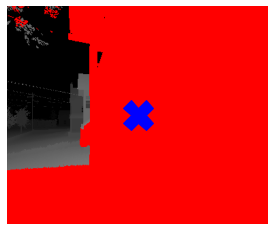

In [3]:
result_image_folder_path = os.path.join(RESULT_PATH, '3D_analysis_all')
if not os.path.exists(result_image_folder_path):
    os.makedirs(result_image_folder_path)

for i in range(50):
    # 讀取影像
    n = "%03d" % (i+1)
    depth, scale = utilkitti.read_pfm(os.path.join(DATA_PATH, str(n)+'.pfm'))
    X = np.zeros((INPUT_HEIGHT, INPUT_WIDTH))
    Y = np.zeros((INPUT_HEIGHT, INPUT_WIDTH))
    im = Image.open(os.path.join(GREY_PIC_PATH, str(n)+'.png'))
    im_rgb = im.convert("RGB")
    danger = False
    for j in range(INPUT_HEIGHT):
        for k in range(INPUT_WIDTH):
            Y[j, k] = depth[j, k] * (j - 160) / 192
            X[j, k] = depth[j, k] * (k - 192) / 192
            if abs(X[j, k]) <= 0.5 and abs(Y[j, k]) <= 0.25:
                if depth[j, k] < 15:
                    danger = True
                  
    #
    #WN N EN E ES S WS W
    safe_count = np.array([0, 0, 0, 0, 0, 0, 0, 0])
    safe_weight_count = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    danger_count = np.array([0, 0, 0, 0, 0, 0, 0, 0])
    danger_weight_count = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    danger_prop = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    safe_dir = 0
    max_safe_weight = 0.0
    danger_area_count = 0
    
    if danger:
        for j in range(INPUT_HEIGHT):
            for k in range(INPUT_WIDTH):
                #if abs(X[j, k]) <= 2.5 and abs(Y[j, k]) <= 2.5:
                    ind_1 = 0
                    ind_2 = 0
                    temp_y = Y[j, k]
                    if Y[j, k] == 0.0:
                        temp_y = 1.0
                        
                    if X[j, k] <= 0.0 and Y[j, k] <= 0.0:
                        ind_1 = 0
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 7
                        else:
                            ind_2 = 1
                    if X[j, k] >= 0.0 and Y[j, k] <= 0.0:
                        ind_1 = 2
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 3
                        else:
                            ind_2 = 1
                    if X[j, k] >= 0.0 and Y[j, k] >= 0.0:
                        ind_1 = 4
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 3
                        else:
                            ind_2 = 5
                    if X[j, k] <= 0.0 and Y[j, k] >= 0.0:
                        ind_1 = 6
                        if abs(X[j, k]/temp_y) > 1:
                            ind_2 = 7
                        else:
                            ind_2 = 5
                        
                    if depth[j, k] > 10:
                        #im_rgb.putpixel((k, j), (0, 256, 0))
                        safe_weight_count[ind_1] += (depth[j, k] * depth[j, k])
                        safe_count[ind_1] += 1
                        safe_weight_count[ind_2] += (depth[j, k] * depth[j, k])
                        safe_count[ind_2] += 1
                    else:
                        im_rgb.putpixel((k, j), (256, 0, 0))
                        danger_weight_count[ind_1] += depth[j, k] ** -10
                        danger_count[ind_1] += 1
                        danger_weight_count[ind_2] += depth[j, k] ** -10
                        danger_count[ind_2] += 1
        for j in range(8):
            danger_prop[j] = danger_weight_count[j] / danger_count[j]
            if math.log(danger_prop[j], 10) < -3.8 and safe_weight_count[j] > max_safe_weight:
                max_safe_weight = safe_weight_count[j]
                safe_dir = j
            else:
                danger_area_count += 1  
    
    pyplot.clf()
    pyplot.axis('off')
    pyplot.imshow(im_rgb)
    if danger:
        #max_area = np.argmax(counter)
        if danger_area_count == 8:
            pyplot.plot(INPUT_WIDTH/2, INPUT_HEIGHT/2, color = 'b', marker = 'X', markersize = 30)
        elif safe_dir == 0:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, -ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 1:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, 0, -ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 2:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, -ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 7:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, 0, color='b', head_width=10)
        elif safe_dir == 3:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, 0, color='b', head_width=10)
        elif safe_dir == 6:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, -ARROW_SIZE, ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 5:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, 0, ARROW_SIZE, color='b', head_width=10)
        elif safe_dir == 4:
            pyplot.arrow(INPUT_WIDTH/2, INPUT_HEIGHT/2, ARROW_SIZE, ARROW_SIZE, color='b', head_width=10)
    # 儲存結果
    pyplot.savefig(os.path.join(result_image_folder_path, str(n)+'.png'))
    print(os.path.join(result_image_folder_path, str(n)+'.png'))
    print(safe_weight_count)
    print(danger_prop)